# Explore the dataset


In this notebook, we will perform an EDA (Exploratory Data Analysis) on the processed Waymo dataset (data in the `processed` folder). In the first part, you will create a function to display 

In [1]:
from utils import get_dataset

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

In [2]:
dataset = get_dataset("./data/waymo/training_and_validation/*.tfrecord")

INFO:tensorflow:Reading unweighted datasets: ['./data/waymo/training_and_validation/*.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['./data/waymo/training_and_validation/*.tfrecord']
INFO:tensorflow:Number of filenames to read: 97
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_deterministic`.
Instructions for updating:
Use `tf.data.Dataset.map()


## Write a function to display an image and the bounding boxes

Implement the `display_instances` function below. This function takes a batch as an input and display an image with its corresponding bounding boxes. The only requirement is that the classes should be color coded (eg, vehicles in red, pedestrians in blue, cyclist in green).

In [3]:
def display_instances(datapoint):
    """
    This function takes a batch from the dataset and display the image with 
    the associated bounding boxes.
    """
    # ADD CODE HEREs
    colors = {
        1:"red", 
        2:"blue", 
        4:"green"
    }
    
    w, h, c = datapoint["image"].shape
    
    
    fig, ax = plt.subplots(figsize=(7,7))
    
    ax.imshow(datapoint["image"].numpy().astype("uint8"))
    
    groundtruth_classes = datapoint["groundtruth_classes"].numpy()
    
    for i in range(len(datapoint["groundtruth_boxes"])):
        ymin, xmin, ymax, xmax = datapoint["groundtruth_boxes"][i]
        ground_class = groundtruth_classes[i]

        rect = matplotlib.patches.Rectangle((xmin*w, ymin*h), (xmax-xmin)*w, (ymax-ymin)*h, 
                                            edgecolor=colors[ground_class], facecolor="none")
        ax.add_patch(rect)
        
    plt.show()
    
    

## Display 10 images 

Using the dataset created in the second cell and the function you just coded, display 10 random images with the associated bounding boxes. You can use the methods `take` and `shuffle` on the dataset.

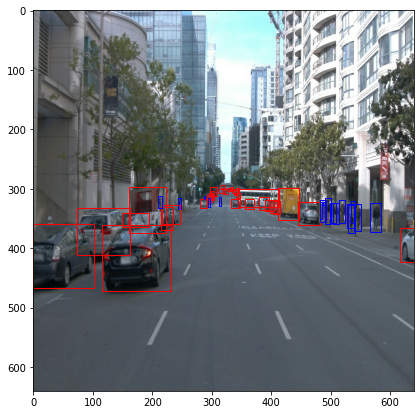

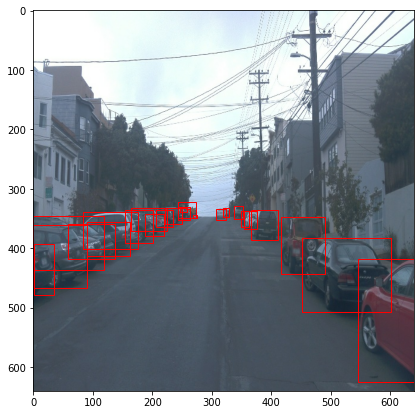

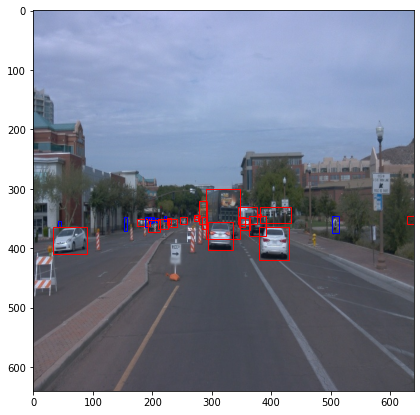

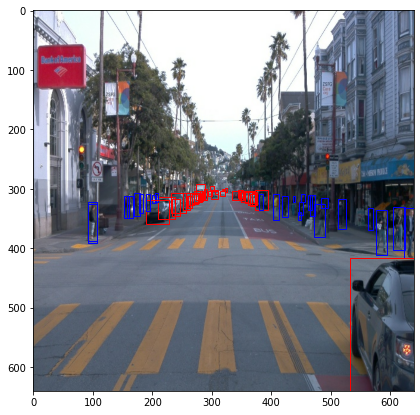

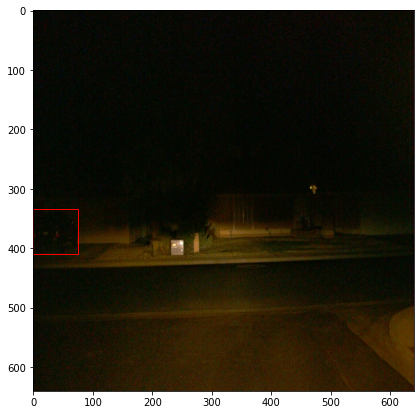

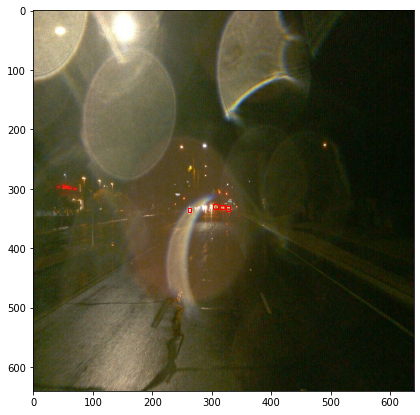

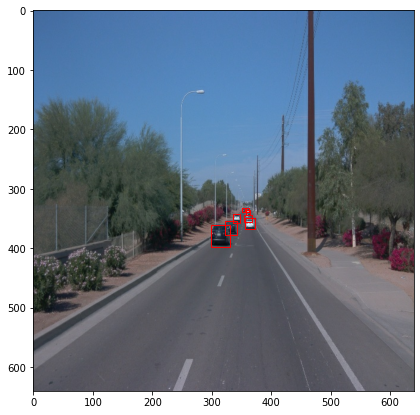

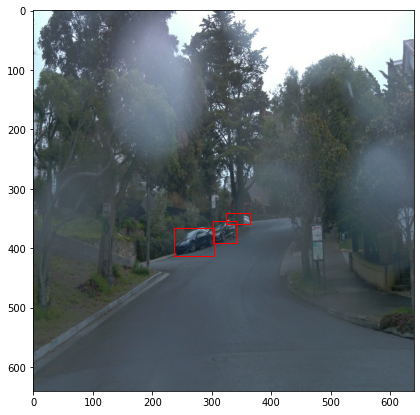

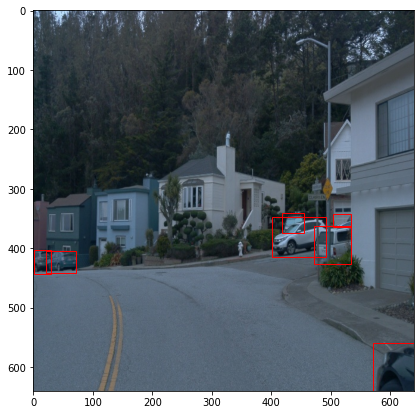

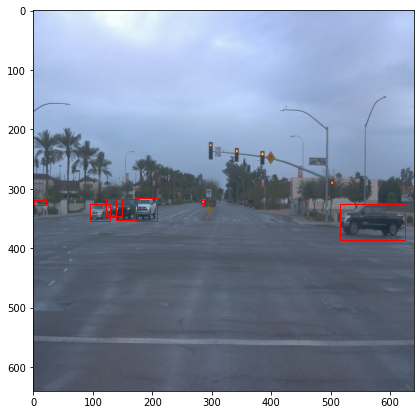

In [4]:
## STUDENT SOLUTION HERE
for datapoint in dataset.take(10):
    display_instances(datapoint)

## Additional EDA

In this last part, you are free to perform any additional analysis of the dataset. What else would like to know about the data?
For example, think about data distribution. So far, you have only looked at a single file...

In [5]:
#Dictionary: Stores count of objects for each class
class_count = {}

#Dictionary: For each class, stores an array how many times this class appears in each image
class_dist = {1:[], 2:[], 4:[]}

"""
positional_dist
-----------------
Dictionary: Stores 10*10*2 array for each class
Split image into 10*10 grid
(10, 10, 2) (x_grid_cells, y_grid_cells, 2)
0th axis stores how many times each class appears in grid cell
1th axis stores total area of objects in grid cell
"""
positional_dist = {}  

for datapoint in tqdm(dataset.take(30000)):
    
    #Initialse class count for current image
    class_dist[1].append(0)
    class_dist[2].append(0)
    class_dist[4].append(0)


            
    for i in range(len(datapoint["groundtruth_classes"])):
        
        groundtruth_classes = datapoint["groundtruth_classes"].numpy()
        groundtruth_boxes = datapoint["groundtruth_boxes"].numpy()
        
        #Maintain number of times each class appear in dataset
        if groundtruth_classes[i] in class_count.keys():
            class_count[groundtruth_classes[i]] += 1
        else:
            class_count[groundtruth_classes[i]] = 1
            
        #Add class count to for current image
        class_dist[groundtruth_classes[i]][-1] += 1
    
    
        #Positional Stats
        
        ymin, xmin, ymax, xmax = groundtruth_boxes[i]
        center_x, center_y = int((xmin+xmax)*10/2), int((ymin+ymax)*10/2)
        if groundtruth_classes[i] not in positional_dist.keys():
            positional_dist[groundtruth_classes[i]] = np.zeros((10,10,2))
            
        positional_dist[groundtruth_classes[i]][center_y, center_x,0] += 1
        
        #Area
        positional_dist[groundtruth_classes[i]][int(ymin*10):int(ymax*10)+1, int(xmin*10):int(xmax*10)+1,1] += 1
        

            
            

30000it [01:28, 340.47it/s]


{1: 539947, 2: 161825, 4: 4204}


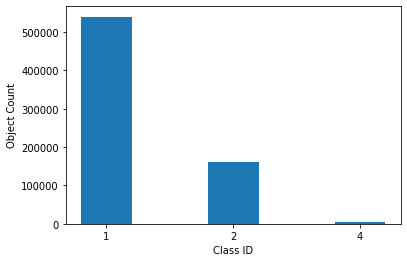

In [6]:
print(class_count)

fig = plt.figure()
classes = [str(x) for x in class_count.keys()]
plt.bar(classes, class_count.values(), width=0.4)
plt.xlabel("Class ID")
plt.ylabel("Object Count")
plt.show()

Distribution of object center in image:


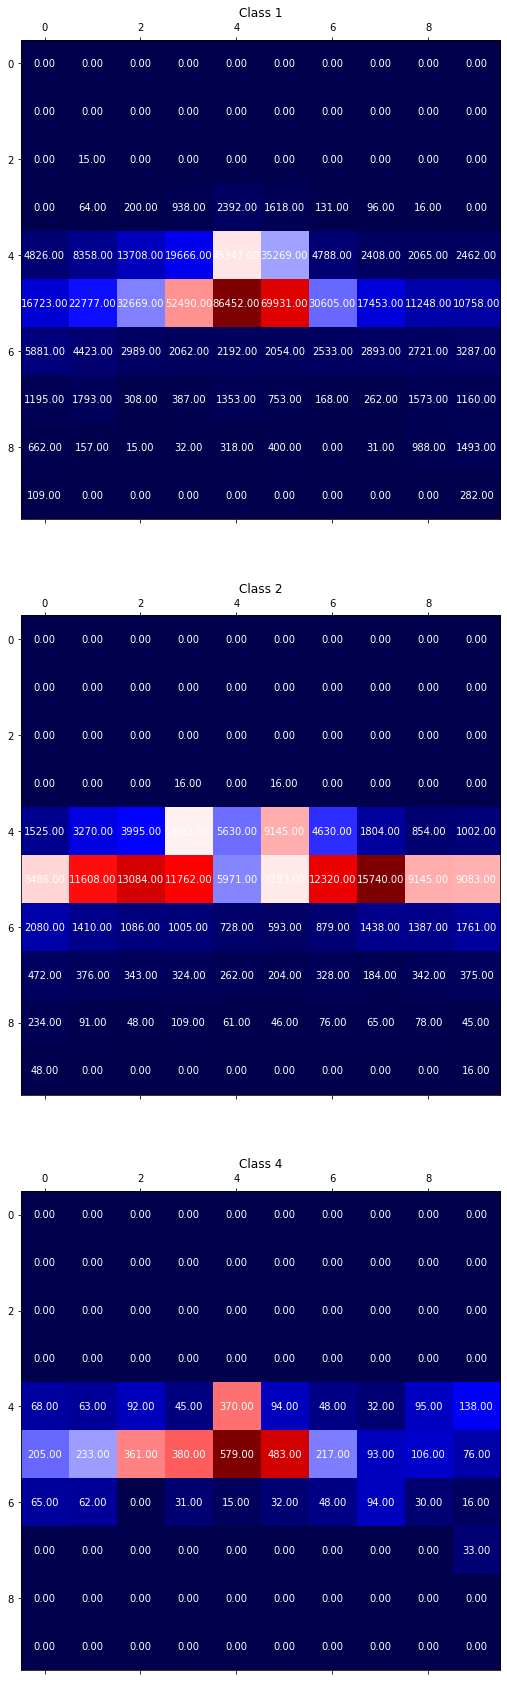

In [7]:
print("Distribution of object center in image:")

fig, ax = plt.subplots(3, 1, figsize=(30,30))

classes = class_count.keys()
for ci in range(len(class_count.keys())):
    class_ = list(class_count.keys())[ci]
    ax[ci].matshow(positional_dist[class_][:,:,0], cmap="seismic")

    s = positional_dist[class_][:,:,0].sum()
    for (i,j), value in np.ndenumerate(positional_dist[class_][:,:,0]):
        ax[ci].text(j, i, "{:0.2f}".format(value), ha="center", va="center", color="white")
        
    ax[ci].set_title("Class " + str(class_))

plt.show()

Distribution of objects area in image:


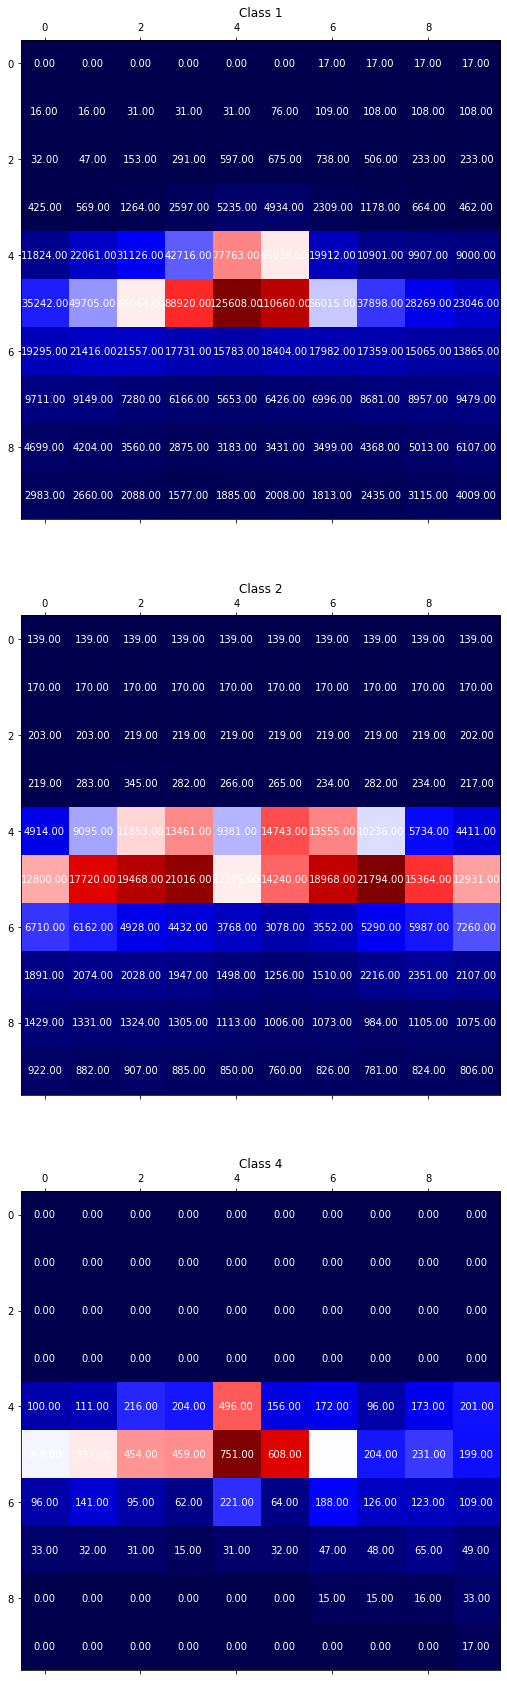

In [8]:
print("Distribution of objects area in image:")

fig, ax = plt.subplots(3, 1, figsize=(30,30))

classes = class_dist.keys()
for ci in range(len(class_dist.keys())):
    class_ = list(class_dist.keys())[ci]
    ax[ci].matshow(positional_dist[class_][:,:,1], cmap="seismic")

    for (i,j), value in np.ndenumerate(positional_dist[class_][:,:,1]):
        ax[ci].text(j, i, "{:0.2f}".format(value), ha="center", va="center", color="white")
        
    ax[ci].set_title("Class " + str(class_))

plt.show()

Frequency bar for each class:


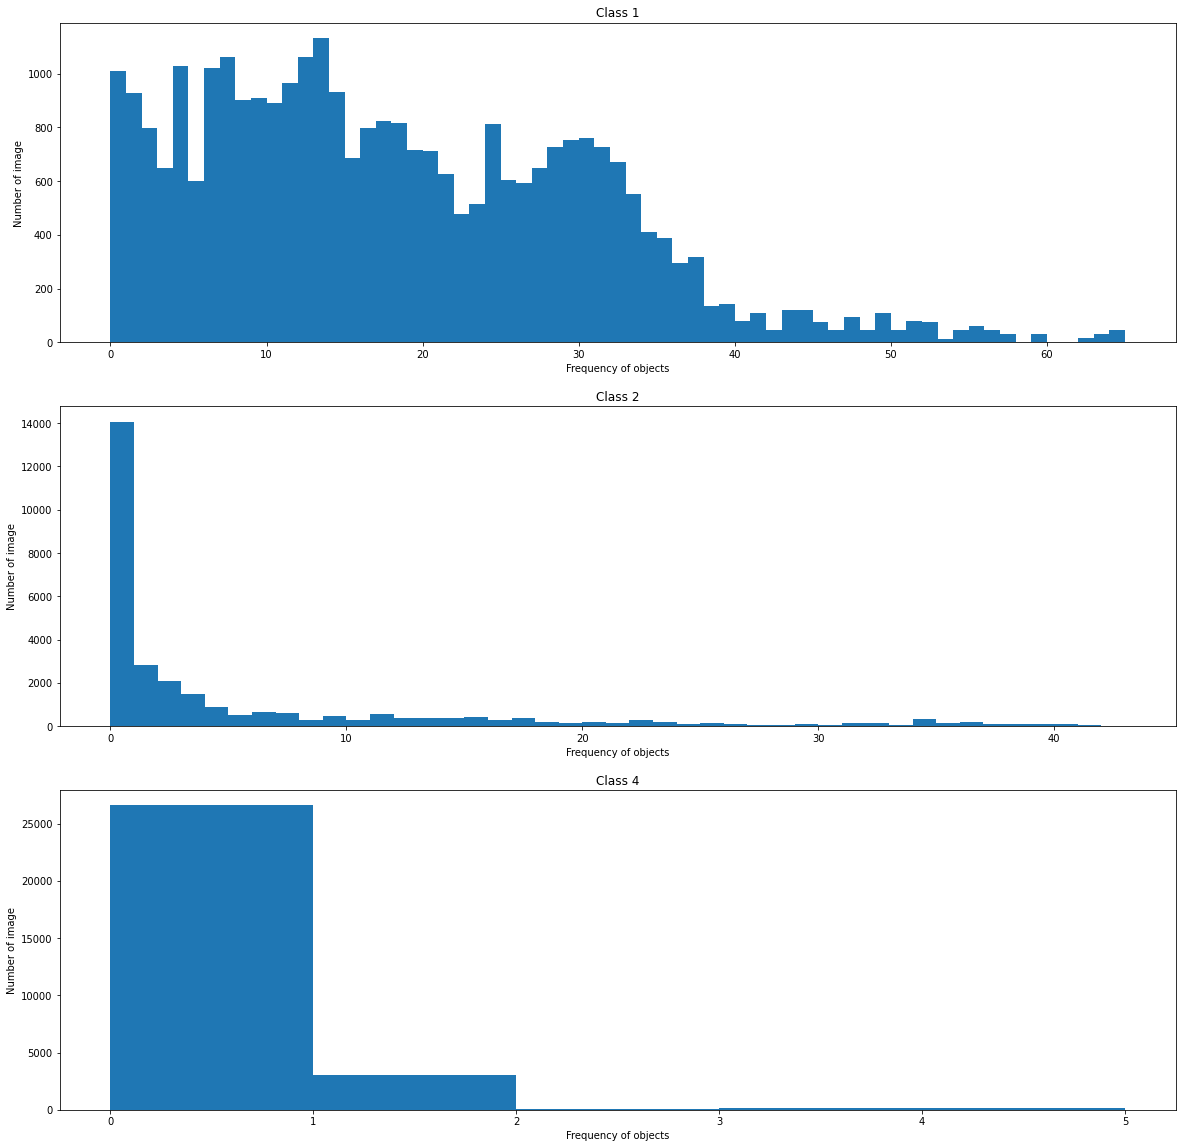

In [9]:
print("Frequency bar for each class vs Number of images:")

fig, ax = plt.subplots(3, 1, figsize=(20,20))

classes = list(class_dist.keys())
for ci in range(len(class_dist.keys())):
    class_ = classes[ci]
    ax[ci].hist(class_dist[class_], bins=range(min(class_dist[class_]), max(class_dist[class_])))
    ax[ci].set_title("Class " + str(class_))
    
    ax[ci].set_ylabel("Number of image")
    ax[ci].set_xlabel("Frequency of objects")

plt.show()